# Import Required Libraries

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score
import pickle
import time

In [168]:
print("NOTEBOOK 08: MODEL TRAINING - RANDOM FOREST CLASSIFIER")

NOTEBOOK 08: MODEL TRAINING - RANDOM FOREST CLASSIFIER


In [169]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Load Prepared Datasets

 Load training and testing sets (Standard scaled)

In [170]:
X_train = np.load('../data/processed/ml_ready/X_train_scaled.npy')
X_test = np.load('../data/processed/ml_ready/X_test_scaled.npy')
y_train = np.load('../data/processed/ml_ready/y_train.npy')
y_test = np.load('../data/processed/ml_ready/y_test.npy')

Load feature names

In [171]:
with open('../data/processed/ml_ready/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

Load label encoder

In [172]:
with open('../models/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)


In [173]:
print("Data Loaded Successfully.")
print(f"Training samples:{X_train.shape[0]:,}")
print(f"Testing samples:{X_test.shape[0]:,}")
print(f"Number of features:{X_train.shape[1]:,}")
print(f"Number of classes:{len(np.unique(y_train)):,}")

Data Loaded Successfully.
Training samples:1,760
Testing samples:440
Number of features:39
Number of classes:22


# Initialize and Train Random Forest Model

In [174]:
print("TRAINING RANDOM FOREST MODEL")

TRAINING RANDOM FOREST MODEL


Model configuration

In [175]:
rf_params={
    'n_estimators': 100,           # Number of trees in forest
    'criterion': 'gini',           # Splitting criterion
    'max_depth': 20,               # Maximum tree depth
    'min_samples_split': 5,        # Min samples to split node
    'min_samples_leaf': 2,         # Min samples in leaf
    'max_features': 'sqrt',        # Features per split = √n
    'bootstrap': True,             # Use bootstrap sampling
    'oob_score': True,             # Calculate out-of-bag score
    'random_state': 42,            # Reproducibility
    'n_jobs': -1,                  # Use all CPU cores prathamesh
    'verbose': 0                   # Suppress training output
}

In [176]:
print("Random Forest Configuration:")
for param, value in rf_params.items():
    print(f"{param}: {value}")


Random Forest Configuration:
n_estimators: 100
criterion: gini
max_depth: 20
min_samples_split: 5
min_samples_leaf: 2
max_features: sqrt
bootstrap: True
oob_score: True
random_state: 42
n_jobs: -1
verbose: 0


Initialize model

In [177]:
rf_model=RandomForestClassifier(**rf_params)

Train model

In [178]:
print("Training Random Forest (100 trees)...")
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print("Model Trained Successfully.")
print(f"Training Time:{training_time:.2f} seconds")
print(f"Number of Trees:{len(rf_model.estimators_)}")
print(f"OOB Score:{rf_model.oob_score_*100:.2f} %")
print("Trees trained in parallel: Yes")

Training Random Forest (100 trees)...
Model Trained Successfully.
Training Time:0.38 seconds
Number of Trees:100
OOB Score:99.38 %
Trees trained in parallel: Yes


Get tree statistics

In [179]:
tree_depths=[estimator.get_depth() for estimator in rf_model.estimators_]
tree_leaves=[estimator.get_n_leaves() for estimator in rf_model.estimators_]

In [180]:
print("Forest Statistics:")
print(f"Average Tree Depth:{np.mean(tree_depths):.1f}")
print(f"Max tree depth:{np.max(tree_depths)}")
print(f"Min tree depth:{np.min(tree_depths)}")
print(f"Average Number of Leaves per Tree:{np.mean(tree_leaves):.1f}")

Forest Statistics:
Average Tree Depth:13.4
Max tree depth:17
Min tree depth:9
Average Number of Leaves per Tree:56.9


# Make Predictions

In [181]:
print("MAKING PREDICTIONS")

MAKING PREDICTIONS


Predictions on training set

In [182]:
print("Making predictions on training data...")
start_time = time.time()
y_train_pred = rf_model.predict(X_train)
y_train_pred_proba=rf_model.predict_proba(X_train)
train_prediction_time = time.time() - start_time

Making predictions on training data...


Predictions on testing set

In [183]:
print("Making predictions on testing data...")
start_time = time.time()
y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)
test_pred_time = time.time() - start_time

Making predictions on testing data...


In [184]:
print("Prediction Completed.")
print(f"Train prediction time:{train_prediction_time:.4f} seconds")
print(f"Test prediction time:{test_pred_time:.4f} seconds")
print(f"Average prediction time per sample: {test_pred_time/len(y_test)*1000:.4f} ms")

Prediction Completed.
Train prediction time:0.1366 seconds
Test prediction time:0.1130 seconds
Average prediction time per sample: 0.2568 ms


In [185]:
print("SaMpLE PREDICTIONS (First 10 test samples):")
sample_df = pd.DataFrame({
    'True_Label': [label_encoder.classes_[i] for i in y_test[:10]],
    'Predicted_Label': [label_encoder.classes_[i] for i in y_test_pred[:10]],
    'Confidence': [np.max(y_test_pred_proba[i]) * 100 for i in range(10)],
    'Match': ['OK' if y_test[i] == y_test_pred[i] else 'NO' for i in range(10)]
})
print(sample_df.to_string(index=True))

SaMpLE PREDICTIONS (First 10 test samples):
  True_Label Predicted_Label  Confidence Match
0     orange          orange   97.500000    OK
1     banana          banana  100.000000    OK
2     cotton          cotton   99.100000    OK
3      maize           maize  100.000000    OK
4     orange          orange   93.083333    OK
5   chickpea        chickpea  100.000000    OK
6       rice            rice   95.392857    OK
7  blackgram       blackgram   94.309524    OK
8     banana          banana   96.833333    OK
9     orange          orange   99.750000    OK


# Model Performance Metrics

In [186]:
print("Model performance evaluation and metrics calculation")

Model performance evaluation and metrics calculation


Calculate metrics for training set

In [187]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision=precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_recall=recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_f1=f1_score(y_train, y_train_pred, average='weighted', zero_division=0)   

Calculate metrics for testing set

In [188]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision=precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall=recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1=f1_score(y_test, y_test_pred, average='weighted', zero_division=0)   

In [189]:
print("Training set performance:")
print(f"Accuracy: {train_accuracy*100:.2f} %")
print(f"Precision: {train_precision*100:.2f} %")
print(f"Recall: {train_recall*100:.2f} %")
print(f"F1-Score: {train_f1*100:.2f} %")

Training set performance:
Accuracy: 99.89 %
Precision: 99.89 %
Recall: 99.89 %
F1-Score: 99.89 %


In [190]:
print("Testing set performance:")
print(f"Accuracy: {test_accuracy*100:.2f} %")
print(f"Precision: {test_precision*100:.2f} %")
print(f"Recall: {test_recall*100:.2f} %")
print(f"F1-Score: {test_f1*100:.2f} %")

Testing set performance:
Accuracy: 99.32 %
Precision: 99.35 %
Recall: 99.32 %
F1-Score: 99.32 %


In [191]:
print("Out of Bag (OOB) Score:")
print(f"OOB Score: {rf_model.oob_score_*100:.2f} %")

Out of Bag (OOB) Score:
OOB Score: 99.38 %


 Check for overfitting

In [192]:
print("Overfitting Analysis:")
accuracy_diff = train_accuracy - test_accuracy
print(f"Train-tes tAccuracy Difference Gap: {accuracy_diff*100:.2f} %")

Overfitting Analysis:
Train-tes tAccuracy Difference Gap: 0.57 %


In [193]:
if accuracy_diff<0.01:
    print("Status:Excellent - No Overfitting Detected")
elif accuracy_diff<0.03:
    print("Staus: Very Good - Minimal Overfitting")
elif accuracy_diff<0.05:
    print("Status: Good - Moderate Overfitting")
else:
    print("Status:Poor - Significant Overfitting")

Status:Excellent - No Overfitting Detected


In [194]:
print("\n" + "="*80)
print("MODEL COMPARISON: LR vs DT vs RF")
print("="*80)

# Load previous model results
try:
    lr_summary = pd.read_csv('../data/results/logistic_regression_summary.csv')
    dt_summary = pd.read_csv('../data/results/decision_tree_summary.csv')
    
    comparison = pd.DataFrame({
        'Metric': [
            'Test Accuracy',
            'Test Precision',
            'Test Recall',
            'Test F1-Score',
            'Training Time (sec)',
            'Prediction Time (ms)',
            'Overfitting Gap'
        ],
        'Logistic_Regression': [
            f"{lr_summary['Test_Accuracy'].values[0] * 100:.2f}%",
            f"{lr_summary['Test_Precision'].values[0] * 100:.2f}%",
            f"{lr_summary['Test_Recall'].values[0] * 100:.2f}%",
            f"{lr_summary['Test_F1'].values[0] * 100:.2f}%",
            f"{lr_summary['Training_Time_sec'].values[0]:.4f}",
            f"{lr_summary['Prediction_Time_ms'].values[0]:.4f}",
            f"{lr_summary['Overfitting_Gap'].values[0] * 100:.2f}%"
        ],
        'Decision_Tree': [
            f"{dt_summary['Test_Accuracy'].values[0] * 100:.2f}%",
            f"{dt_summary['Test_Precision'].values[0] * 100:.2f}%",
            f"{dt_summary['Test_Recall'].values[0] * 100:.2f}%",
            f"{dt_summary['Test_F1'].values[0] * 100:.2f}%",
            f"{dt_summary['Training_Time_sec'].values[0]:.4f}",
            f"{dt_summary['Prediction_Time_ms'].values[0]:.4f}",
            f"{dt_summary['Overfitting_Gap'].values[0] * 100:.2f}%"
        ],
        'Random_Forest': [
            f"{test_accuracy * 100:.2f}%",
            f"{test_precision * 100:.2f}%",
            f"{test_recall * 100:.2f}%",
            f"{test_f1 * 100:.2f}%",
            f"{training_time:.4f}",
            f"{test_pred_time/len(y_test)*1000:.4f}",
            f"{accuracy_diff * 100:.2f}%"
        ]
    })
    
    print("\n")
    print(comparison.to_string(index=False))
    
    # Determine winner
    lr_acc = lr_summary['Test_Accuracy'].values[0]
    dt_acc = dt_summary['Test_Accuracy'].values[0]
    rf_acc = test_accuracy
    
    print(f"\n🏆 WINNER:")
    if rf_acc > dt_acc and rf_acc > lr_acc:
        print(f"  • Random Forest: {rf_acc * 100:.2f}% ✅ (BEST MODEL)")
        improvement_lr = (rf_acc - lr_acc) * 100
        improvement_dt = (rf_acc - dt_acc) * 100
        print(f"  • Improvement over LR: +{improvement_lr:.2f}%")
        print(f"  • Improvement over DT: +{improvement_dt:.2f}%")
    
    # Save comparison
    comparison.to_csv('../data/results/model_comparison_all.csv', index=False)
    print("\n✅ Comparison saved to: ../data/results/model_comparison_all.csv")
    
except FileNotFoundError:
    print("\n⚠️  Previous model results not found. Skipping comparison.")


MODEL COMPARISON: LR vs DT vs RF


              Metric Logistic_Regression Decision_Tree Random_Forest
       Test Accuracy              97.73%        95.68%        99.32%
      Test Precision              97.93%        95.92%        99.35%
         Test Recall              97.73%        95.68%        99.32%
       Test F1-Score              97.71%        95.70%        99.32%
 Training Time (sec)              0.2027        0.0194        0.3761
Prediction Time (ms)              0.0028        0.0042        0.2568
     Overfitting Gap               1.14%         1.88%         0.57%

🏆 WINNER:
  • Random Forest: 99.32% ✅ (BEST MODEL)
  • Improvement over LR: +1.59%
  • Improvement over DT: +3.64%

✅ Comparison saved to: ../data/results/model_comparison_all.csv


# Cross-Validation Score

In [195]:
print("Cross-Validation Analysis:")

Cross-Validation Analysis:


In [196]:
print("Performing 5-Fold Cross-Validation")
#Use for validating model stability

Performing 5-Fold Cross-Validation


In [197]:
cv_scores=cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("Cross validation completed")
print("CV Scores for each fold:")
for i,score in enumerate(cv_scores,1):
    print(f"Fold {i}: {score*100:.2f} %")

Cross validation completed
CV Scores for each fold:
Fold 1: 99.43 %
Fold 2: 99.15 %
Fold 3: 100.00 %
Fold 4: 99.72 %
Fold 5: 98.30 %


In [198]:
print("CV Statistics")
print(f"Mean CV Accuracy: {np.mean(cv_scores)*100:.2f} %")
print(f"Std Dev of CV Accuracy: {np.std(cv_scores)*100:.2f} %")
print(f"Min Cv Accuracy: {np.min(cv_scores)*100:.2f} %")
print(f"Max Cv Accuracy: {np.max(cv_scores)*100:.2f} %")

CV Statistics
Mean CV Accuracy: 99.32 %
Std Dev of CV Accuracy: 0.58 %
Min Cv Accuracy: 98.30 %
Max Cv Accuracy: 100.00 %


In [199]:
if cv_scores.std()<0.02:
    print("Model is very stable (low variance across folds)")
elif cv_scores.std()<0.05:
    print("Model is moderately stable (acceptable variance across folds)")
else:
    print("Model is unstable (high variance across folds)")

Model is very stable (low variance across folds)


# Detailed Classification Report

In [200]:
print("DETAILED CLASSIFICATION REPORT")

DETAILED CLASSIFICATION REPORT


In [201]:
print("CLASSIFICATION REPORT (Testing Set):")
report = classification_report(
    y_test, 
    y_test_pred, 
    target_names=label_encoder.classes_,
    digits=4
)
print(report)

CLASSIFICATION REPORT (Testing Set):
              precision    recall  f1-score   support

       apple     1.0000    1.0000    1.0000        20
      banana     1.0000    1.0000    1.0000        20
   blackgram     1.0000    1.0000    1.0000        20
    chickpea     1.0000    1.0000    1.0000        20
     coconut     1.0000    1.0000    1.0000        20
      coffee     1.0000    1.0000    1.0000        20
      cotton     0.9524    1.0000    0.9756        20
      grapes     1.0000    1.0000    1.0000        20
        jute     0.9524    1.0000    0.9756        20
 kidneybeans     1.0000    1.0000    1.0000        20
      lentil     1.0000    0.9500    0.9744        20
       maize     1.0000    0.9500    0.9744        20
       mango     1.0000    1.0000    1.0000        20
   mothbeans     0.9524    1.0000    0.9756        20
    mungbean     1.0000    1.0000    1.0000        20
   muskmelon     1.0000    1.0000    1.0000        20
      orange     1.0000    1.0000    1.0000 

In [202]:
report_dict = classification_report(
    y_test, 
    y_test_pred, 
    target_names=label_encoder.classes_,
    output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

In [203]:
report_df

,precision,recall,f1-score,support
apple,1.0000,1.0000,1.0000,20.0000
banana,1.0000,1.0000,1.0000,20.0000
blackgram,1.0000,1.0000,1.0000,20.0000
chickpea,1.0000,1.0000,1.0000,20.0000
coconut,1.0000,1.0000,1.0000,20.0000
coffee,1.0000,1.0000,1.0000,20.0000
cotton,0.9524,1.0000,0.9756,20.0000
grapes,1.0000,1.0000,1.0000,20.0000
jute,0.9524,1.0000,0.9756,20.0000
kidneybeans,1.0000,1.0000,1.0000,20.0000


# Confusion Matrix

In [204]:
print("Confusion Matrix")

Confusion Matrix


In [205]:
cm=confusion_matrix(y_test, y_test_pred)

In [206]:
print("Confusion Matrix Shape:",cm.shape)

Confusion Matrix Shape: (22, 22)


Create heatmap

Saved: 34_random_forest_confusion_matrix.png


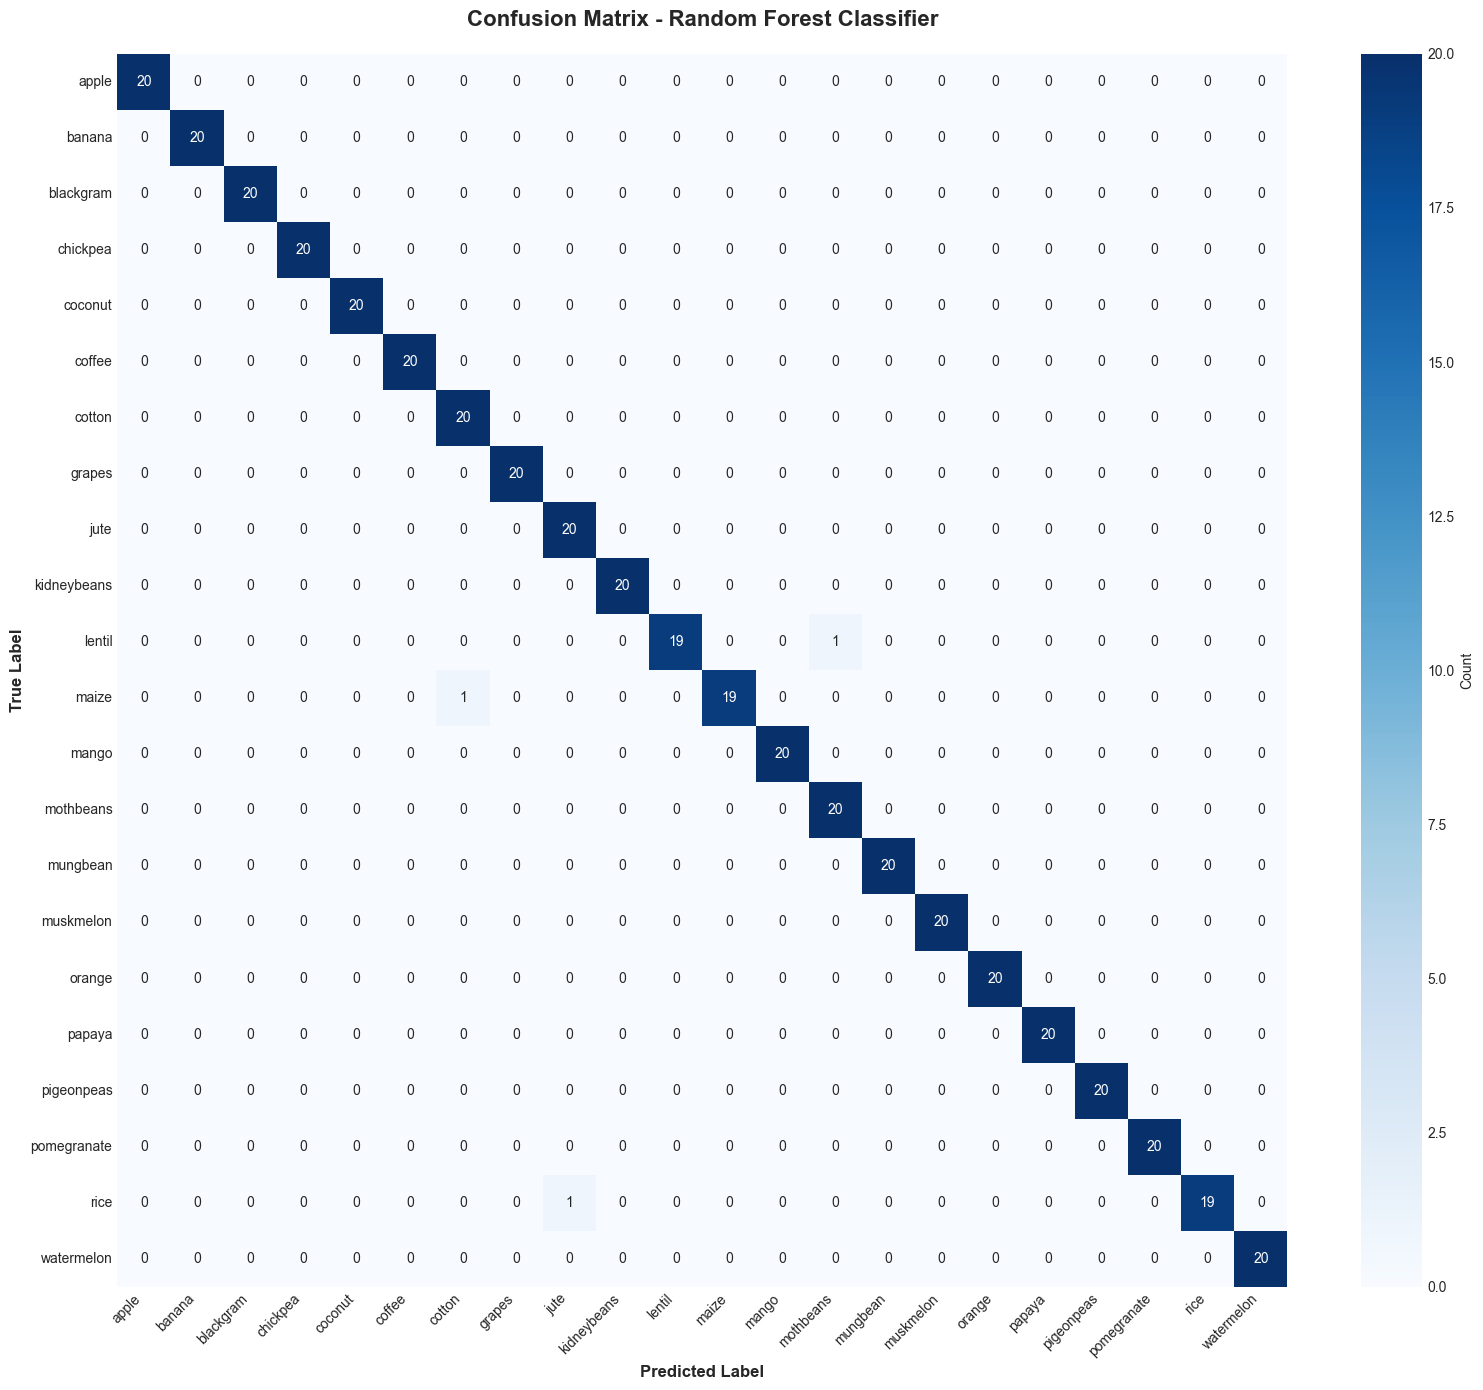

In [207]:
plt.figure(figsize=(16,14))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,cbar_kws={"label":"Count"})

plt.title("Confusion Matrix - Random Forest Classifier", fontsize=16,fontweight='bold',pad=20)
plt.xlabel("Predicted Label", fontsize=12,fontweight='bold')
plt.ylabel("True Label", fontsize=12,fontweight='bold')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('../data/visualizations/34_random_forest_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: 34_random_forest_confusion_matrix.png")
plt.show()

Normalized confusion matrix

In [208]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Saved: 35_random_forest_confusion_matrix_normalized.png


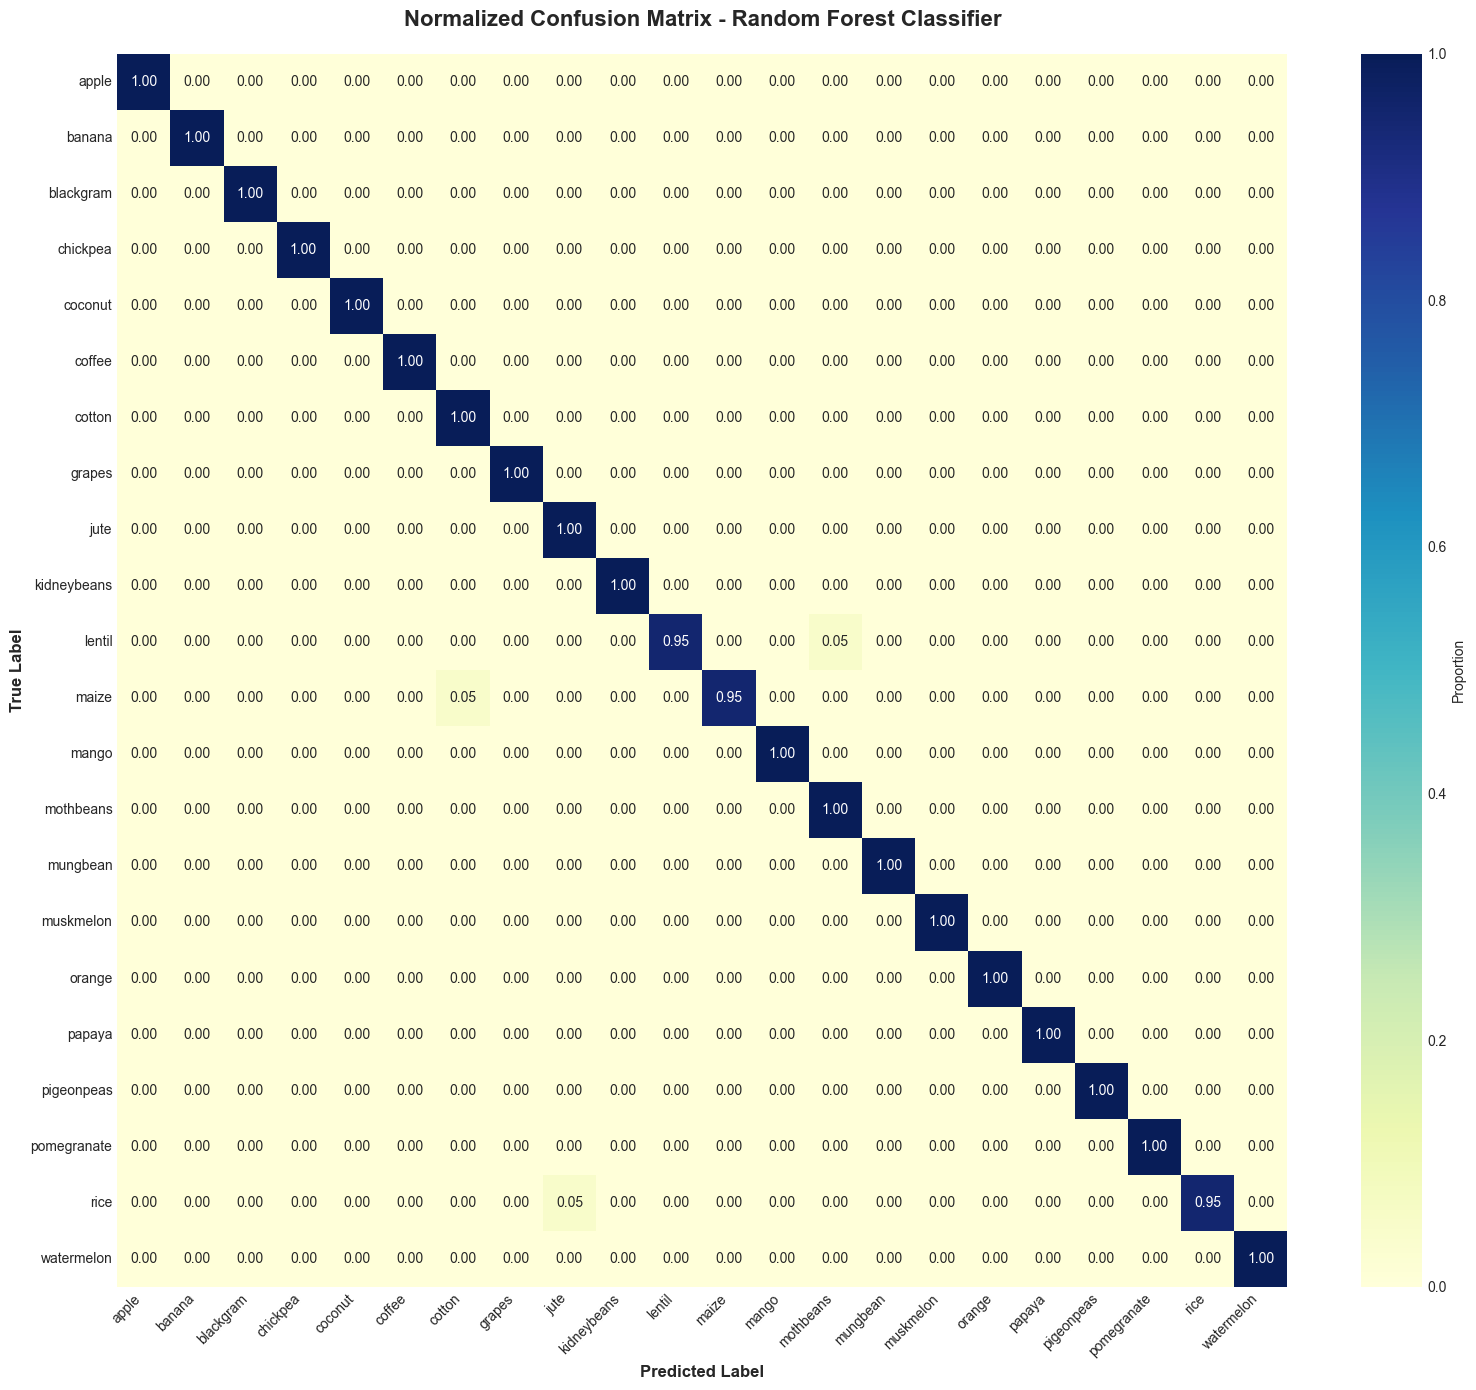

In [209]:
plt.figure(figsize=(16,14))
sns.heatmap(cm_normalized,annot=True,fmt=".2f",cmap="YlGnBu",xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,cbar_kws={"label":"Proportion"})

plt.title("Normalized Confusion Matrix - Random Forest Classifier", fontsize=16,fontweight='bold',pad=20)
plt.xlabel("Predicted Label", fontsize=12,fontweight='bold')
plt.ylabel("True Label", fontsize=12,fontweight='bold')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('../data/visualizations/35_random_forest_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print("Saved: 35_random_forest_confusion_matrix_normalized.png")
plt.show()

Feature Importance Analysis

In [210]:
print("Feature importance analysis")

Feature importance analysis


Get feature importance (averaged across all trees)

In [211]:
feature_importance=rf_model.feature_importances_

In [212]:
feature_importance_df=pd.DataFrame({
    "Feature":feature_names,
    "Importance":feature_importance
}).sort_values(by="Importance", ascending=False)

In [213]:
print("Top 20 most important features:")
print(feature_importance_df.head(20).to_string(index=False))

Top 20 most important features:
                  Feature  Importance
                 rainfall    0.078593
                 humidity    0.077212
                        K    0.064936
           moisture_index    0.055347
       water_availability    0.054124
        rainfall_per_temp    0.049494
         K_ph_interaction    0.041671
                        P    0.041427
       water_stress_index    0.040329
                  NPK_sum    0.038797
                        N    0.037279
    resource_availability    0.034035
            climate_index    0.031929
temp_humidity_interaction    0.031821
         P_ph_interaction    0.031512
              NPK_product    0.030912
             P_to_K_ratio    0.026739
              K_dominance    0.024419
        heat_stress_index    0.023161
              P_dominance    0.022864


Visualize top 20 features

Saved:36_random_forest_feature_importance.png


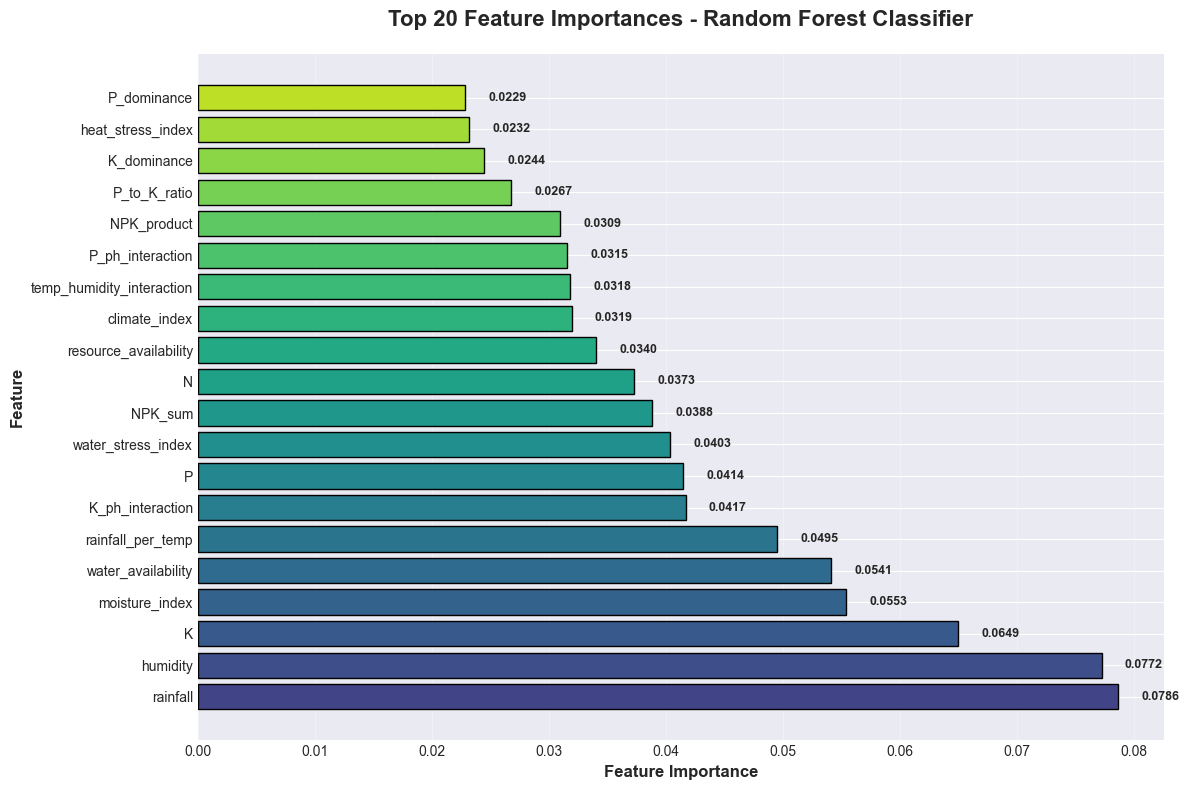

In [214]:
plt.figure(figsize=(12,8))
top_20_features=feature_importance_df.head(20)
colors=plt.cm.viridis(np.linspace(0.2,0.9,20))
bars = plt.barh(range(20), top_20_features['Importance'].values, color=colors, edgecolor='black')

plt.yticks(range(20), top_20_features['Feature'].values)
plt.xlabel("Feature Importance", fontsize=12,fontweight='bold')
plt.ylabel("Feature", fontsize=12,fontweight='bold')
plt.title("Top 20 Feature Importances - Random Forest Classifier", fontsize=16,fontweight='bold',pad=20)
plt.grid(axis='x',alpha=0.3)

for i, val in enumerate(top_20_features['Importance'].values):
    plt.text(val + 0.002, i, f'{val:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../data/visualizations/36_random_forest_feature_importance.png', dpi=300, bbox_inches='tight')
print("Saved:36_random_forest_feature_importance.png")
plt.show()

Save Feature importance

In [215]:
feature_importance_df.to_csv('../data/results/random_forest_feature_importance.csv', index=False)
print("Feature importance saved to: ../data/results/random_forest_feature_importance.csv")

Feature importance saved to: ../data/results/random_forest_feature_importance.csv


In [216]:
try:
    dt_importance = pd.read_csv('../data/results/decision_tree_feature_importance.csv')
    
    print(f"\nFEATURE IMPORTANCE COMPARISON (Top 10):")
    comparison_fi = pd.DataFrame({
        'Feature': feature_importance_df.head(10)['Feature'].values,
        'RF_Importance': feature_importance_df.head(10)['Importance'].values,
        'DT_Importance': [dt_importance[dt_importance['Feature'] == f]['Importance'].values[0] 
                          if f in dt_importance['Feature'].values else 0 
                          for f in feature_importance_df.head(10)['Feature'].values]
    })
    print(comparison_fi.to_string(index=False))
    
except FileNotFoundError:
    print("\nDecision Tree feature importance not found. Skipping comparison.")


FEATURE IMPORTANCE COMPARISON (Top 10):
           Feature  RF_Importance  DT_Importance
          rainfall       0.078593       0.000000
          humidity       0.077212       0.149447
                 K       0.064936       0.050028
    moisture_index       0.055347       0.037040
water_availability       0.054124       0.049270
 rainfall_per_temp       0.049494       0.092499
  K_ph_interaction       0.041671       0.003426
                 P       0.041427       0.080326
water_stress_index       0.040329       0.021524
           NPK_sum       0.038797       0.049346


# Per-Class Performance Analysis

In [217]:
print("PER-CLASS PERFORMANCE ANALYSIS")

PER-CLASS PERFORMANCE ANALYSIS


Extract per-class metrics

In [218]:
class_metrics = []
for i, crop in enumerate(label_encoder.classes_):
    class_metrics.append({
        'Crop': crop,
        'Precision': report_dict[crop]['precision'],
        'Recall': report_dict[crop]['recall'],
        'F1-Score': report_dict[crop]['f1-score'],
        'Support': report_dict[crop]['support']
    })

In [219]:
class_metrics_df=pd.DataFrame(class_metrics)
class_metrics_df=class_metrics_df.sort_values('F1-Score', ascending=False)

In [220]:
print("Top 5 best performing crops based of f1-score:")
print(class_metrics_df.head(5).to_string(index=False))

Top 5 best performing crops based of f1-score:
     Crop  Precision  Recall  F1-Score  Support
    apple        1.0     1.0       1.0     20.0
   banana        1.0     1.0       1.0     20.0
blackgram        1.0     1.0       1.0     20.0
 chickpea        1.0     1.0       1.0     20.0
  coconut        1.0     1.0       1.0     20.0


In [221]:
print("Top 5 worst performing crops based of f1-score:")
print(class_metrics_df.tail(5).to_string(index=False))

Top 5 worst performing crops based of f1-score:
     Crop  Precision  Recall  F1-Score  Support
     jute   0.952381    1.00  0.975610     20.0
mothbeans   0.952381    1.00  0.975610     20.0
    maize   1.000000    0.95  0.974359     20.0
   lentil   1.000000    0.95  0.974359     20.0
     rice   1.000000    0.95  0.974359     20.0



Saved: 37_random_forest_per_class_performance.png


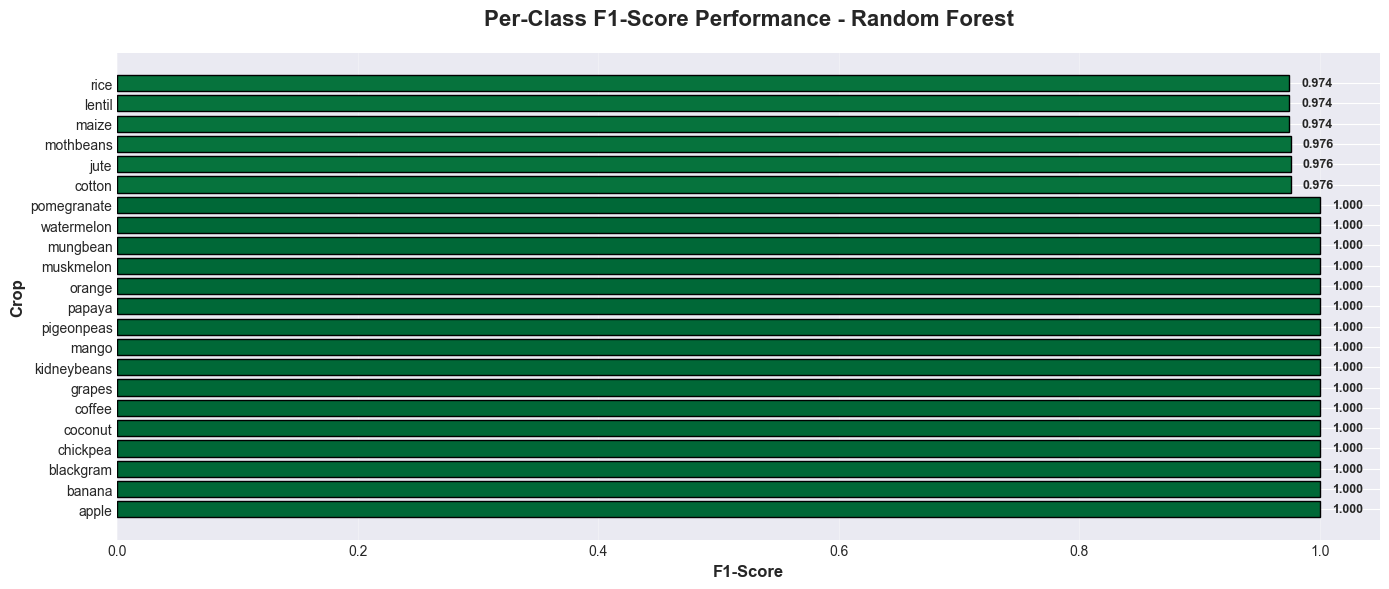

In [222]:
plt.figure(figsize=(14, 6))
colors = plt.cm.RdYlGn(class_metrics_df['F1-Score'])
bars = plt.barh(class_metrics_df['Crop'], class_metrics_df['F1-Score'], color=colors, edgecolor='black')

plt.xlabel('F1-Score', fontsize=12, fontweight='bold')
plt.ylabel('Crop', fontsize=12, fontweight='bold')
plt.title('Per-Class F1-Score Performance - Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.xlim(0, 1.05)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (crop, score) in enumerate(zip(class_metrics_df['Crop'], class_metrics_df['F1-Score'])):
    plt.text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../data/visualizations/37_random_forest_per_class_performance.png', dpi=300, bbox_inches='tight')
print("\nSaved: 37_random_forest_per_class_performance.png")
plt.show()

# Tree Ensemble Statistics

In [223]:
print("Forest Ensemble Statistics")

Forest Ensemble Statistics


In [224]:
print("Ensemble Diversity Metrics:")

Ensemble Diversity Metrics:


Saved: 38_random_forest_tree_diversity.png


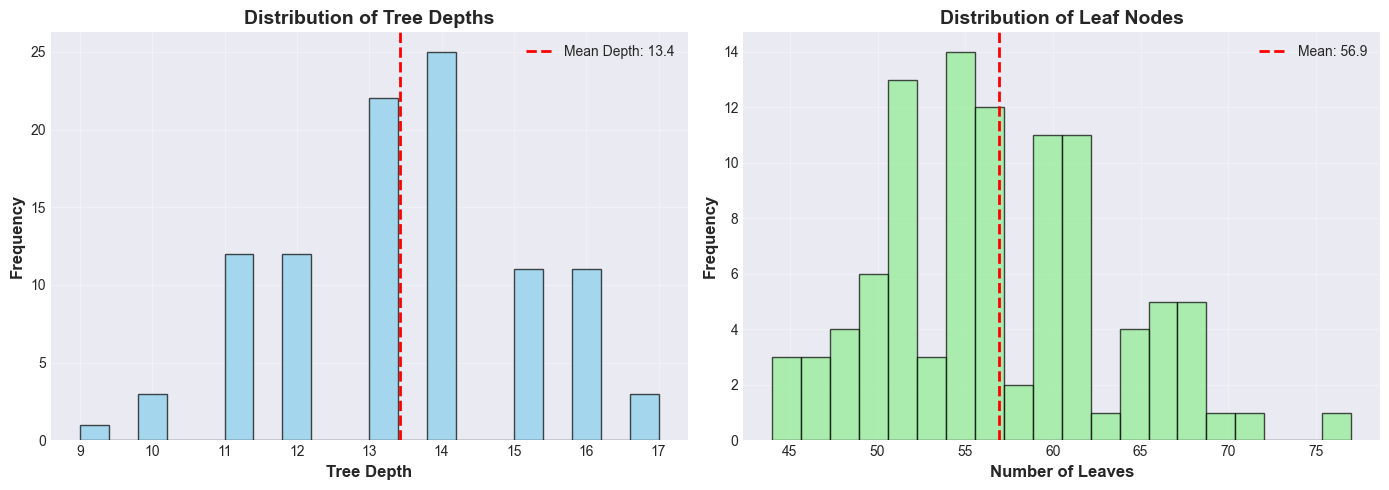

In [225]:
plt.figure(figsize=(14,5))

# Subplot 1: Tree Depth Distribution
plt.subplot(1,2,1)
plt.hist(tree_depths,bins=20,color="skyblue",edgecolor="black",alpha=0.7)
plt.axvline(np.mean(tree_depths),color="red",linestyle="--",linewidth=2,label=f"Mean Depth: {np.mean(tree_depths):.1f}")

plt.xlabel('Tree Depth',fontsize=12, fontweight='bold')
plt.ylabel('Frequency',fontsize=12, fontweight='bold')
plt.title('Distribution of Tree Depths',fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

#Subplot 2: Number of Leaves Distribution
plt.subplot(1,2,2)
plt.hist(tree_leaves, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(tree_leaves), color='red', linestyle='--', linewidth=2,label=f'Mean: {np.mean(tree_leaves):.1f}')

plt.xlabel('Number of Leaves', fontsize=12, fontweight='bold')
plt.ylabel('Frequency',fontsize=12, fontweight='bold')
plt.title('Distribution of Leaf Nodes',fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/visualizations/38_random_forest_tree_diversity.png', dpi=300, bbox_inches='tight')
print("Saved: 38_random_forest_tree_diversity.png")
plt.show()

In [226]:
print("Diversity Metrics")
print(f"Depth Variance: {np.var(tree_depths):.2f}")
print(f"Leaf Variance: {np.var(tree_leaves):.2f}")
print(f"Depth range: [{np.min(tree_depths)}, {np.max(tree_depths)}]")
print(f"Leaf range: [{np.min(tree_leaves)}, {np.max(tree_leaves)}]")

Diversity Metrics
Depth Variance: 3.01
Leaf Variance: 43.41
Depth range: [9, 17]
Leaf range: [44, 77]


In [227]:
if np.std(tree_depths)>2:
    print("High tree diversity (good for ensemble performance)")
else:
    print("Low tree diversity (trees are similar)")

Low tree diversity (trees are similar)


# Prediction Confidence Analysis

In [228]:
test_confidence=np.max(y_test_pred_proba, axis=1)

In [229]:
print(f"Mean confidence: {test_confidence.mean() * 100:.2f}%")
print(f"Median confidence: {np.median(test_confidence) * 100:.2f}%")
print(f"Min confidence: {test_confidence.min()*100:.2f}%")
print(f"Max confidence: {test_confidence.max()*100:.2f}%")
print(f"Std deviation: {test_confidence.std()*100:.2f}%")

Mean confidence: 94.28%
Median confidence: 98.00%
Min confidence: 46.92%
Max confidence: 100.00%
Std deviation: 9.22%


Saved: 39_random_forest_confidence_distribution.png


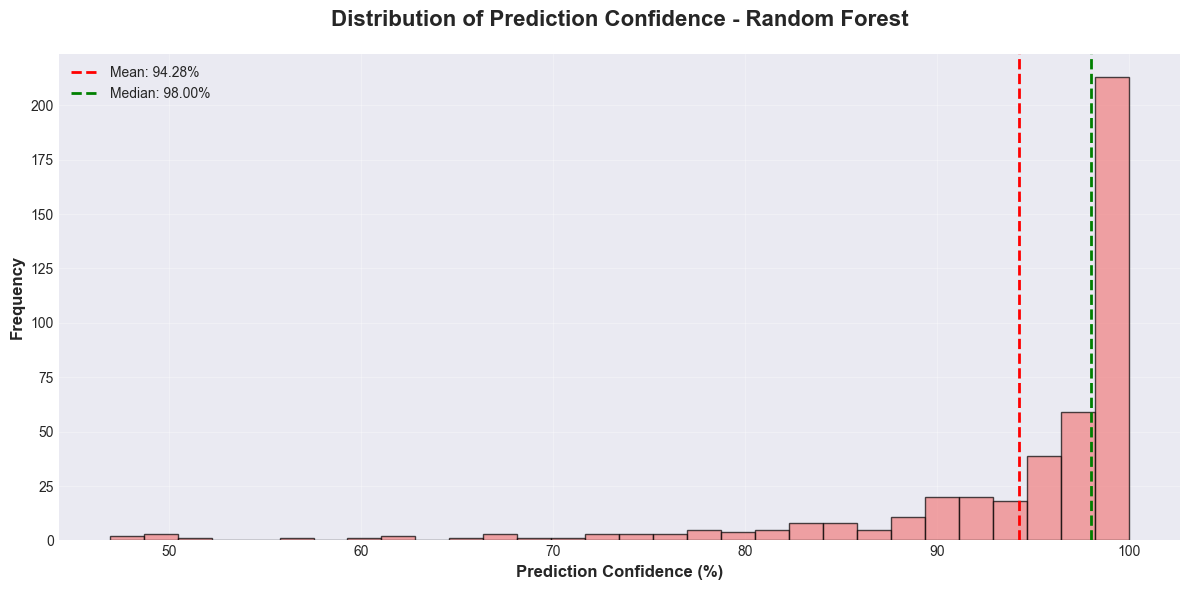

In [230]:
plt.figure(figsize=(12, 6))
plt.hist(test_confidence * 100, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(test_confidence.mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {test_confidence.mean()*100:.2f}%')
plt.axvline(np.median(test_confidence) * 100, color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(test_confidence)*100:.2f}%')
plt.xlabel('Prediction Confidence (%)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Prediction Confidence - Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/visualizations/39_random_forest_confidence_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: 39_random_forest_confidence_distribution.png")
plt.show()

Confidence vs Correctness

In [231]:
correct_mask = y_test == y_test_pred
correct_confidence = test_confidence[correct_mask]
incorrect_confidence = test_confidence[~correct_mask]

In [232]:
print("Confidence by Correctness")
print(f"Correct predictions-Mean confidence: {correct_confidence.mean() * 100:.2f}%")
print(f"Incorrect predictions-Mean confidence: {incorrect_confidence.mean() * 100:.2f}% (if any)")
print(f"Confidence gap:{(correct_confidence.mean() - incorrect_confidence.mean()) * 100:.2f}%")


Confidence by Correctness
Correct predictions-Mean confidence: 94.56%
Incorrect predictions-Mean confidence: 54.20% (if any)
Confidence gap:40.36%


In [233]:
high_conf_mask = test_confidence > 0.95
print("HIGH CONFIDENCE PREDICTIONS (>95%):")
print(f"Count: {high_conf_mask.sum()} ({high_conf_mask.sum()/len(y_test)*100:.1f}%)")
print(f"Accuracy: {accuracy_score(y_test[high_conf_mask], y_test_pred[high_conf_mask]) * 100:.2f}%")

HIGH CONFIDENCE PREDICTIONS (>95%):
Count: 301 (68.4%)
Accuracy: 100.00%


# Save Model and Results

In [234]:
print("SAVING MODEL AND RESULTS")

SAVING MODEL AND RESULTS


In [235]:
import os
model_path = '../models/random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model,f)

In [236]:
print(f"Model size: {os.path.getsize(model_path) / 1024:.2f} KB")

Model size: 2991.89 KB


Save model performance summary

In [237]:
model_summary = {
    'Model': ['Random Forest'],
    'Train_Accuracy': [train_accuracy],
    'Test_Accuracy': [test_accuracy],
    'Train_Precision': [train_precision],
    'Test_Precision': [test_precision],
    'Train_Recall': [train_recall],
    'Test_Recall': [test_recall],
    'Train_F1': [train_f1],
    'Test_F1': [test_f1],
    'OOB_Score': [rf_model.oob_score_],
    'CV_Mean': [cv_scores.mean()],
    'CV_Std': [cv_scores.std()],
    'Training_Time_sec': [training_time],
    'Prediction_Time_ms': [test_pred_time/len(y_test)*1000],
    'N_Estimators': [rf_model.n_estimators],
    'Avg_Tree_Depth': [np.mean(tree_depths)],
    'Overfitting_Gap': [accuracy_diff]
}


In [238]:
summary_df = pd.DataFrame(model_summary)
summary_df.to_csv('../data/results/random_forest_summary.csv', index=False)
print("Performance summary saved to: ../data/results/random_forest_summary.csv")

Performance summary saved to: ../data/results/random_forest_summary.csv


Save predictions

In [239]:
predictions_df = pd.DataFrame({
    'True_Label_Encoded': y_test,
    'Predicted_Label_Encoded': y_test_pred,
    'True_Label': [label_encoder.classes_[i] for i in y_test],
    'Predicted_Label': [label_encoder.classes_[i] for i in y_test_pred],
    'Confidence': np.max(y_test_pred_proba, axis=1),
    'Correct': y_test == y_test_pred
})


In [240]:
predictions_df.to_csv('../data/results/random_forest_predictions.csv', index=False)
print("Performance summary saved to: ../data/results/random_forest_predictions.csv")

Performance summary saved to: ../data/results/random_forest_predictions.csv
